In [1]:
from light_curve import LightCurve
import joblib
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from torchvision import transforms
import aug
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical

2023-05-08 10:28:56.642827: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 10:28:57.117770: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
path_macho = '/home/francisco/Documents/data/macho/full.pkl'
data_macho = joblib.load(path_macho)
path_asas = '/home/francisco/Documents/data/asas/full.pkl'
data_asas = joblib.load(path_asas)
path_linear = '/home/francisco/Documents/data/linear/full.pkl'
data_linear = joblib.load(path_linear)

## Dataset


## Cargar datos,period fold y normalizacion

In [3]:
all_data = data_macho + data_asas + data_linear

In [4]:
max_value = max([lc.max_value() for lc in all_data])
min_value = min([lc.min_value() for lc in all_data])

In [5]:
for lc in all_data:
    lc.normalize(min_value,max_value)
    lc.period_fold()
data_raw = [[lc.times,lc.measurements] for lc in all_data]
X_t = np.array(data_raw).transpose()



/tmp/ipykernel_7375/1791650327.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_t = np.array(data_raw).transpose()


In [6]:
from scipy.signal import resample

In [7]:
M_padded = [resample(x,500) for x in X_t[0]]
T_padded = [resample(x,500) for x in X_t[1]]

In [8]:

classnames, y_inds = np.unique([str(lc.label) for lc in all_data],return_inverse=True)
Y = to_categorical(y_inds, len(classnames))

Y_lab = [list(np.where(p==1))[0][0] for p in Y]

In [9]:
classnames_old = dict(enumerate(classnames))

In [10]:
Y_df = pd.DataFrame(Y_lab)
Y_df.columns = ['label']
M_df = pd.DataFrame(M_padded)
T_df = pd.DataFrame(T_padded)

In [11]:
df_total = pd.concat([Y_df,pd.concat([T_df,M_df],axis=1)],axis=1)

In [12]:
vc = Y_df.value_counts()

threshold = 100
below_threshold = vc[vc < threshold].index
low_classes = below_threshold.to_numpy().tolist()
low_classes_list = [t[0] for t  in low_classes]

In [13]:
df_total = df_total[~df_total['label'].isin(low_classes_list)]

In [14]:
labels = df_total['label']
times = df_total.iloc[:,1:501]
mags = df_total.iloc[:,501:1001]

In [15]:
labels = np.array(labels)
times = np.array(times)
mags = np.array(mags)

In [16]:
curves = np.array([[mags[i],times[i]] for i in range(len(times))])

In [17]:
for i in low_classes_list:
    classnames_old.pop(i)

In [18]:
re_label = []
for i in labels:
    re_label.append(classnames_old[i])


In [19]:
classnames_re, y_inds_re = np.unique([str(lc) for lc in re_label],return_inverse=True)
K = to_categorical(y_inds_re, len(classnames_re))

Y_lab_re = [list(np.where(p==1))[0][0] for p in K]

In [20]:
classnames_re = dict(enumerate(classnames_re))

In [21]:
classnames = dict(enumerate(list(classnames_re.values())))

In [22]:
len(classnames)

20

In [23]:
labels = np.array(Y_lab_re)

## Training Encoder

In [24]:
def train_epoch(model, dataloader, loss_function, optimizer):
  """Funcion para realizar el entrenamiento de una epoca
    Inputs
    -------
    model : torch.model
      modelo a entrenar
    dataloader: torch.dataloader
      datos con los cuales se entrena
    loss_function: torch.loss_fn
      funcion de perdida para el entrenamiento(entropia cruzada)
    optimizer: torch.optimizer
      funcion de optimizacion(adam)
    Returns
    -------
    list:
    entrega un tensor con los valores de ouputs entrenamiento, labels y losses
  """
  model.train()
  train_outputs = []
  train_labels = []
  train_losses = []

  for i,data in enumerate(dataloader):
    targets = data[1].cuda()
    sample = data[0].float().cuda()

    batch_size = targets.shape[0]
    
    outputs = model(sample)
    loss = loss_function(outputs, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_losses.append(loss.item()*batch_size)
    train_outputs.append(outputs.detach())
    train_labels.append(targets.detach())

  return torch.tensor(train_losses), torch.cat(train_outputs), torch.cat(train_labels)

In [25]:
def val_epoch(model, dataloader, loss_function):
  """Funcion para realizar la validacion de una epoca
    Inputs
    -------
    model : torch.model
      modelo a entrenar
    dataloader: torch.dataloader
      datos con los cuales se entrena
    loss_function: torch.loss_fn
      funcion de perdida para el entrenamiento(entropia cruzada)
    Returns
    -------
    list:
    entrega un tensor con los valores de ouputs validacion, labels y losses
  """
  model.eval()
  val_outputs= []
  val_labels = []
  val_losses = []

  with torch.no_grad():
    for i,data in enumerate(dataloader):
      targets = data[1].cuda()
      sample = data[0].float().cuda()

      batch_size = targets.shape[0]

      outputs = model(sample)

      loss = loss_function(outputs, targets)

      val_losses.append(loss.item()*batch_size)
      val_outputs.append(outputs.detach())
      val_labels.append(targets.detach())

  return torch.tensor(val_losses), torch.cat(val_outputs), torch.cat(val_labels)

In [26]:
def get_scores(losses, outputs, labels):
  """Funcion obtener escores a partir de losses outputs y labels
  Inputs
  -------
  losses : list
    lista de losses
  outputs : list
    lista de outputs
  labels : list
    lista con los labels
  Returns
  -------
  acc: float
    valor de accuracy
  loss: float
    valor de loss
  
    """
  pred = torch.argmax(outputs, dim=1).cpu().numpy()
  true_label = labels.cpu().numpy()
  num = labels.shape[0]
  loss = torch.sum(losses).item()/num
  acc = accuracy_score(true_label, pred)
  return loss, acc

In [27]:
def curva_entrenamiento(loss_train, loss_val, titulo):
  """Funcion que permite graficar la curva de entrenamiento
  Inputs
  -------
  loss_train : list
    lista de losses entrenamiento
  loss_val : list
    lista de losses validacion
  titulo : str
    titulo del grafico

  """
  epochs = len(loss_train)
  epoch_list = np.arange(1, epochs+1)
  plt.plot(epoch_list, loss_train, label = "Train")
  plt.plot(epoch_list, loss_val, label = "Validation")
  plt.legend()
  plt.title(titulo)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

In [28]:
import torch.nn.functional as F
class MyNet4(nn.Module):


  def __init__(self):
    super(MyNet4, self).__init__()#(32,32,3)
    
    self.nclasses = 20
    self.conv1 = nn.Conv1d(2, 64, kernel_size=3, padding=1)  #(64,64,64)
    self.bn1 = nn.BatchNorm1d(64)
    self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1) #(64,64,64)
    self.bn2 = nn.BatchNorm1d(64)
    self.mpool1 = nn.MaxPool1d(kernel_size = 2, stride = 2) #(64,32,32)
    self.conv3 = nn.Conv1d(64,64, kernel_size=3, padding=1) #(64,32,32)
    self.bn3 = nn.BatchNorm1d(64)
    self.conv4 = nn.Conv1d(64,64, kernel_size=3, padding=1)#(64,32,32)
    self.bn4 = nn.BatchNorm1d(64)
    self.conv5 = nn.Conv1d(64,64, kernel_size=3, padding=1)#(64,32,32)
    self.bn5 = nn.BatchNorm1d(64)
    self.mpool2 = nn.MaxPool1d(kernel_size = 2, stride = 2) #(64,16,16)
    self.fc1 = nn.Linear(8000, 2048)
    self.fc2 = nn.Linear(2048, 1024)
    self.fc_last = nn.Linear(1024, self.nclasses)
    
  def forward(self, x):

    x = self.bn1(F.relu(self.conv1(x)))
    x = self.bn2(F.relu(self.conv2(x)))
    x = self.mpool1(x)
    x = self.bn3(F.relu(self.conv3(x)))
    x = self.bn4(F.relu(self.conv4(x)))
    x = self.bn5(F.relu(self.conv5(x)))
    x = self.mpool2(x)
    x = x.view(x.size()[0], -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc_last(x)
    return x

In [29]:
BATCH_SIZE = 64
LR = 1e-3
epochs = 20

In [30]:
device ='cuda'

In [31]:
encoder = MyNet4()
encoder.to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(encoder.parameters(), lr=LR)

In [32]:
x_tot, x_enc, y_tot, y_enc = train_test_split(curves,labels,test_size=0.2)
x_train, x_vt, y_train, y_vt = train_test_split(x_enc,y_enc,test_size=0.4)
x_test, x_val, y_test, y_val = train_test_split(x_vt,y_vt,test_size=0.5)
data_train = [y_train,x_train]
data_val = [y_val,x_val]
data_test = [y_test,x_test]

In [33]:
class data_LC(Dataset):
    def __init__(self,input,label,device='cuda'):
        self.data = torch.tensor(input,dtype=torch.float)
        self.labels = torch.tensor(label)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        return self.data[index],self.labels[index]

In [34]:
dataset_train = data_LC(x_train,y_train)
dataset_val = data_LC(x_val,y_val)
dataset_test = data_LC(x_test,y_test)
train_loader_base = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle =True, pin_memory=True)
val_loader_base = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle =True, pin_memory=True)
test_loader_base = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle =True, pin_memory=True)


In [35]:
best_param_net3_path = 'best_param_encoder.bin'

In [36]:
TORCH_USE_CUDA_DSA = 1
CUDA_LAUNCH_BLOCKING=1

In [37]:
best_val_loss = np.inf
loss_train = []
loss_val = []
not_improve_epochs = 0
tolerance = 5
epoch = 0
while not_improve_epochs<tolerance:
  epoch+=1
  print(f"Epoch {epoch}/{epochs}")
  train_loss, train_out, train_targets = train_epoch(encoder, train_loader_base, criterion, optimizer)
  loss, acc = get_scores(train_loss, train_out, train_targets)
  loss_train.append(loss)
  print("Train Loss: {:.3f}\tTrain Acc: {:.3f}".format(loss, acc))

  val_loss, val_out, val_targets = val_epoch(encoder, val_loader_base, criterion)
  loss, acc = get_scores(val_loss, val_out, val_targets)
  loss_val.append(loss)
  print("Validation Loss: {:.3f}\tValidation Acc: {:.3f}".format(loss, acc))

  if loss < best_val_loss :
    torch.save(encoder.state_dict(),best_param_net3_path)
    best_val_loss = loss
    not_improve_epochs=0
  else:
    not_improve_epochs+=1

Epoch 1/20
Train Loss: 0.814	Train Acc: 0.747
Validation Loss: 0.581	Validation Acc: 0.808
Epoch 2/20
Train Loss: 0.554	Train Acc: 0.811
Validation Loss: 0.978	Validation Acc: 0.669
Epoch 3/20
Train Loss: 0.546	Train Acc: 0.813
Validation Loss: 0.675	Validation Acc: 0.761
Epoch 4/20
Train Loss: 0.512	Train Acc: 0.821
Validation Loss: 0.816	Validation Acc: 0.695
Epoch 5/20
Train Loss: 0.492	Train Acc: 0.825
Validation Loss: 0.926	Validation Acc: 0.664
Epoch 6/20
Train Loss: 0.484	Train Acc: 0.832
Validation Loss: 1.321	Validation Acc: 0.644


In [38]:
encoder.load_state_dict(torch.load(best_param_net3_path))

<All keys matched successfully>

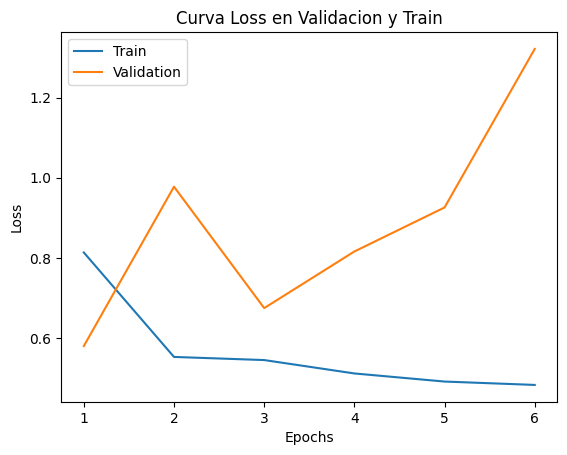

In [39]:
curva_entrenamiento(loss_train,loss_val,"Curva Loss en Validacion y Train")

                   precision    recall  f1-score   support

      Beta_Persei      0.000     0.000     0.000        83
         Ceph 1st      0.000     0.000     0.000        74
        Ceph Fund      0.621     0.654     0.637       133
Classical_Cepheid      0.000     0.000     0.000        18
      Delta_Scuti      0.000     0.000     0.000        13
               EB      0.693     0.423     0.525       844
        LPV WoodA      0.000     0.000     0.000        37
        LPV WoodB      0.313     0.847     0.457       111
        LPV WoodC      0.376     0.259     0.306       147
        LPV WoodD      0.641     0.272     0.382        92
             Mira      0.000     0.000     0.000       224
             None      0.885     0.998     0.938      5363
         RRL + GB      0.000     0.000     0.000        30
           RRL AB      0.807     0.984     0.887       869
            RRL C      0.513     0.982     0.674       228
            RRL E      0.000     0.000     0.000       

/home/francisco/anaconda3/envs/cl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/francisco/anaconda3/envs/cl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/francisco/anaconda3/envs/cl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

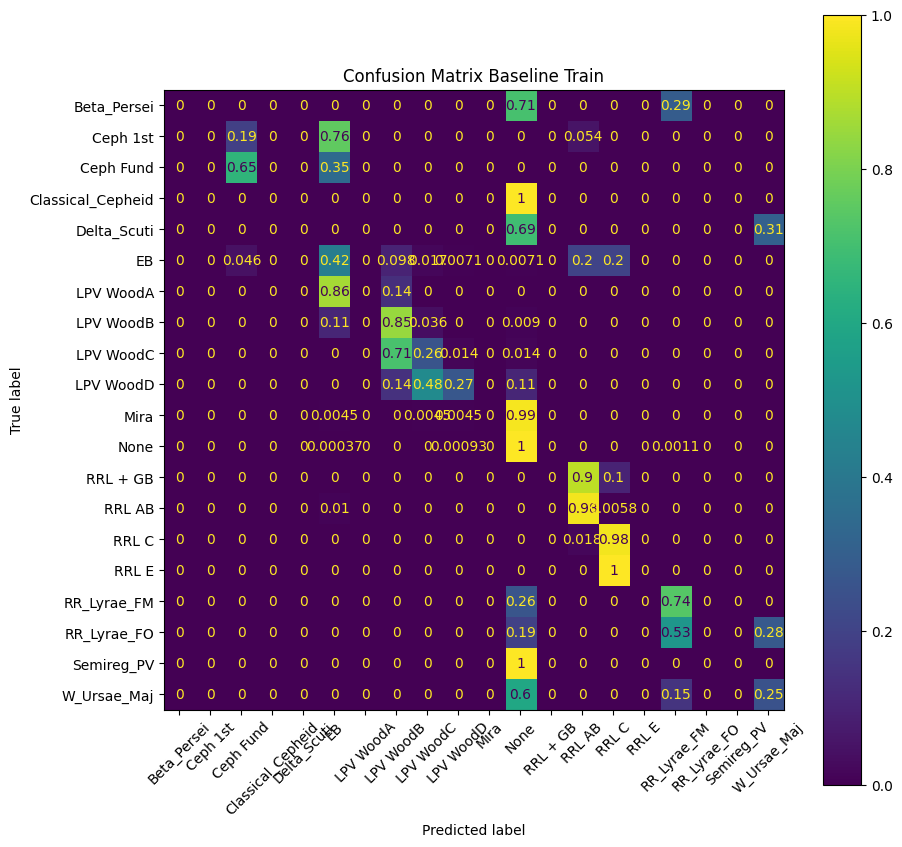

In [40]:
loss, preds, targets = val_epoch(encoder, train_loader_base, criterion)

preds = torch.argmax(preds, dim=1).cpu().numpy()
targets = targets.cpu().numpy()

print(classification_report(targets, preds, target_names =  classnames.values(),digits=3))

conf_m = confusion_matrix(targets, preds, normalize='true')
cmp=ConfusionMatrixDisplay(conf_m,display_labels = classnames.values())
fig, ax = plt.subplots(figsize=(10,10))
title = 'Confusion Matrix Baseline Train'
ax.set_title(title)
fig.set_facecolor('white')
cmp.plot(ax=ax,xticks_rotation=45)

                   precision    recall  f1-score   support

      Beta_Persei      0.000     0.000     0.000        20
         Ceph 1st      0.000     0.000     0.000        24
        Ceph Fund      0.683     0.651     0.667        43
Classical_Cepheid      0.000     0.000     0.000         6
      Delta_Scuti      0.000     0.000     0.000         4
               EB      0.710     0.458     0.557       288
        LPV WoodA      0.000     0.000     0.000        10
        LPV WoodB      0.272     0.880     0.415        25
        LPV WoodC      0.278     0.238     0.256        42
        LPV WoodD      0.688     0.324     0.440        34
             Mira      0.000     0.000     0.000        67
             None      0.883     0.996     0.936      1781
         RRL + GB      0.000     0.000     0.000        10
           RRL AB      0.799     0.972     0.877       282
            RRL C      0.549     1.000     0.709        78
            RRL E      0.000     0.000     0.000       

/home/francisco/anaconda3/envs/cl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/francisco/anaconda3/envs/cl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/francisco/anaconda3/envs/cl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

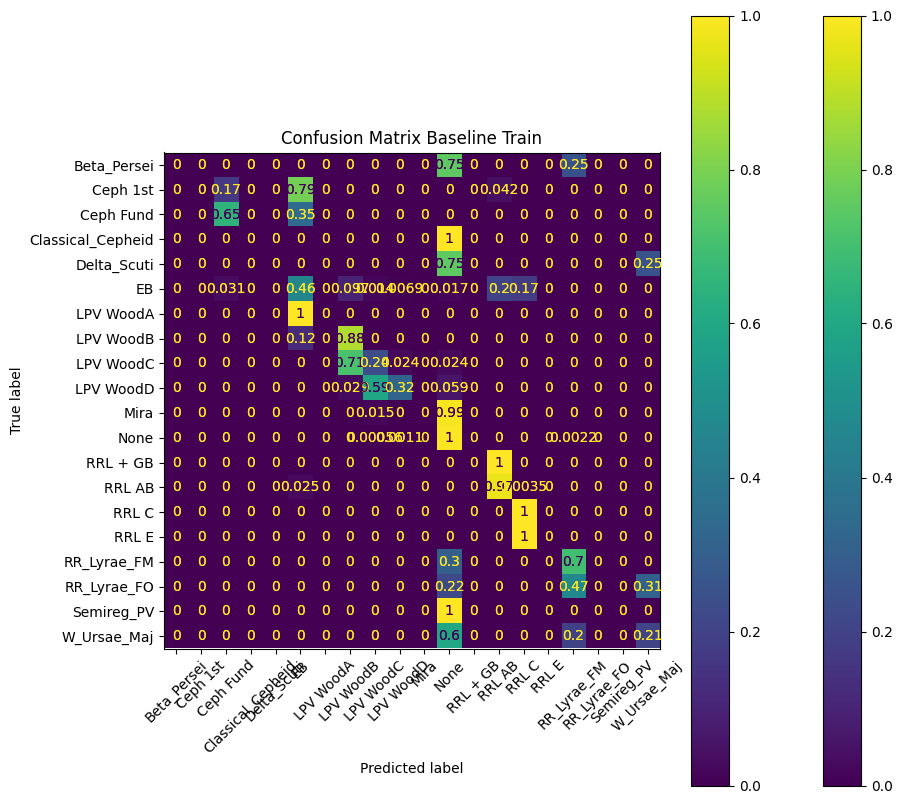

In [41]:
loss, preds, targets = val_epoch(encoder, test_loader_base, criterion)

preds = torch.argmax(preds, dim=1).cpu().numpy()
targets = targets.cpu().numpy()

print(classification_report(targets, preds, target_names =  classnames.values(),digits=3))

conf_m = confusion_matrix(targets, preds, normalize='true')
cmp=ConfusionMatrixDisplay(conf_m,display_labels = classnames.values())
fig, ax = plt.subplots(figsize=(10,10))
title = 'Confusion Matrix Baseline Train'
ax.set_title(title)
fig.set_facecolor('white')
cmp.plot(ax=ax,xticks_rotation=45)
cmp.plot(ax=ax,xticks_rotation=45)

In [51]:
import torch.nn.functional as F
class MyNet5(nn.Module):


  def __init__(self):
    super(MyNet5, self).__init__()#(32,32,3)
    
    self.nclasses = 20
    self.conv1 = nn.Conv1d(2, 64, kernel_size=3, padding=1)  #(64,64,64)
    self.bn1 = nn.BatchNorm1d(64)
    self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1) #(64,64,64)
    self.bn2 = nn.BatchNorm1d(64)
    self.mpool1 = nn.MaxPool1d(kernel_size = 2, stride = 2) #(64,32,32)
    self.conv3 = nn.Conv1d(64,64, kernel_size=3, padding=1) #(64,32,32)
    self.bn3 = nn.BatchNorm1d(64)
    self.conv4 = nn.Conv1d(64,64, kernel_size=3, padding=1)#(64,32,32)
    self.bn4 = nn.BatchNorm1d(64)
    self.conv5 = nn.Conv1d(64,64, kernel_size=3, padding=1)#(64,32,32)
    self.bn5 = nn.BatchNorm1d(64)
    self.mpool2 = nn.MaxPool1d(kernel_size = 2, stride = 2) #(64,16,16)
    self.fc1 = nn.Linear(8000, 2048)
    self.fc2 = nn.Linear(2048, 1024)
    self.fc_last = nn.Linear(1024, self.nclasses)
    
  def forward(self, x):

    x = self.bn1(F.relu(self.conv1(x)))
    x = self.bn2(F.relu(self.conv2(x)))
    x = self.mpool1(x)
    x = self.bn3(F.relu(self.conv3(x)))
    x = self.bn4(F.relu(self.conv4(x)))
    x = self.bn5(F.relu(self.conv5(x)))
    x = self.mpool2(x)
    x = x.view(x.size()[0], -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x

In [52]:
encoder_weighted = MyNet5()
encoder_weighted.load_state_dict(torch.load(best_param_net3_path))

<All keys matched successfully>

## Train Self-Supervised

In [42]:
class NormalizedEuclideanDistance(object):
    def __init__(self, dim, eps=1e-6):
        self.dim = dim
        self.eps = eps

    def __call__(self, x, y):
        z = (x - y).pow(2).sum(1) / self.dim
        return z, (z + self.eps).sqrt()

In [43]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=1, distance_fun_name='euclidean', nl=16):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.distance_fun_name = distance_fun_name
        if self.distance_fun_name == "euclidean":
            self.forward_fun = self.contrastive_with_euclidean
            self.norm_euclidean_distance = NormalizedEuclideanDistance(nl)
        elif self.distance_fun_name == "cosine":
            self.forward_fun = self.contrastive_with_cosine
            self.cosine_distance = torch.nn.CosineSimilarity()
        self.relu = torch.nn.ReLU()

    def contrastive_with_cim(self, x1, x2, y_bar):
        cim2, cim = self.cim(x1, x2)
        loss = 0.5 * (1 - y_bar) * cim2 + 0.5 * y_bar * self.relu(self.margin - cim).pow(2)
        return loss.mean()

    def contrastive_with_euclidean(self, x1, x2, y_bar):
        dw2, dw = self.norm_euclidean_distance(x1, x2)
        loss = 0.5 * (1 - y_bar) * dw2 + 0.5 * y_bar * self.relu(self.margin - dw).pow(2)
        return loss.mean()

    def contrastive_with_cosine(self, x1, x2, y_bar):
        dw = 1 - self.cosine_distance(x1, x2)
        loss = 0.5 * ((1 - y_bar) * dw + y_bar * self.relu(self.margin - dw))
        return loss.mean()

    def forward(self, z, y):
        indices1 = torch.randperm(len(z))
        indices2 = torch.randperm(len(z))
        y_bar = torch.logical_or(y[indices1] != y[indices2], (y[indices1] == -99) * (y[indices2] == -99)) * 1.
        loss = self.forward_fun(z[indices1], z[indices2], y_bar)
        return loss

In [44]:
def train_epoch_ssl(model, dataloader, loss_function, optimizer):
  """Funcion para realizar el entrenamiento de una epoca
    Inputs
    -------
    model : torch.model
      modelo a entrenar
    dataloader: torch.dataloader
      datos con los cuales se entrena
    loss_function: torch.loss_fn
      funcion de perdida para el entrenamiento(entropia cruzada)
    optimizer: torch.optimizer
      funcion de optimizacion(adam)
    Returns
    -------
    list:
    entrega un tensor con los valores de ouputs entrenamiento, labels y losses
  """
  model.train()
  train_outputs = []
  train_labels = []
  train_losses = []

  for data in dataloader:
    targets = data[1].cuda()
    sample = data[0].float().cuda()
    seq_len = data[2]
    batch_size = targets.shape[0]

    outputs = model([sample[0],sample[1],seq_len])
    loss = loss_function(outputs, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_losses.append(loss.item()*batch_size)
    train_outputs.append(outputs.detach())
    train_labels.append(targets.detach())

  return torch.tensor(train_losses), torch.cat(train_outputs), torch.cat(train_labels)

In [45]:
def val_epoch_ssl(model, dataloader, loss_function):
  """Funcion para realizar la validacion de una epoca
    Inputs
    -------
    model : torch.model
      modelo a entrenar
    dataloader: torch.dataloader
      datos con los cuales se entrena
    loss_function: torch.loss_fn
      funcion de perdida para el entrenamiento(entropia cruzada)
    Returns
    -------
    list:
    entrega un tensor con los valores de ouputs validacion, labels y losses
  """
  model.eval()
  val_outputs= []
  val_labels = []
  val_losses = []

  with torch.no_grad():
    for data in dataloader:
      targets = data[1].cuda()
      sample = data[0].float().cuda()
      seq_len = data[2]
      batch_size = targets.shape[0]

      outputs = model([sample[0],sample[1],seq_len])

      loss = loss_function(outputs, targets)

      val_losses.append(loss.item()*batch_size)
      val_outputs.append(outputs.detach())
      val_labels.append(targets.detach())

  return torch.tensor(val_losses), torch.cat(val_outputs), torch.cat(val_labels)

In [46]:
best_val_loss = np.inf
loss_train = []
loss_val = []
not_improve_epochs = 0
tolerance = 5
epoch = 0
while not_improve_epochs<tolerance:
  epoch+=1
  print(f"Epoch {epoch}/{epochs}")
  train_loss, train_out, train_targets = train_epoch_ssl(encoder, train_loader_base, criterion, optimizer)
  loss, acc = get_scores(train_loss, train_out, train_targets)
  loss_train.append(loss)
  print("Train Loss: {:.3f}\tTrain Acc: {:.3f}".format(loss, acc))

  val_loss, val_out, val_targets = val_epoch_ssl(encoder, val_loader_base, criterion)
  loss, acc = get_scores(val_loss, val_out, val_targets)
  loss_val.append(loss)
  print("Validation Loss: {:.3f}\tValidation Acc: {:.3f}".format(loss, acc))

  if loss < best_val_loss :
    torch.save(encoder.state_dict(),best_param_net3_path)
    best_val_loss = loss
    not_improve_epochs=0
  else:
    not_improve_epochs+=1

Epoch 1/20


IndexError: list index out of range

In [ ]:
a = 2